In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import itertools
from tqdm import tqdm

# SARIMA model
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [2]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

In [3]:
# Prédire février 2005 et mars 2005. Entraîner de février 2003 à janvien 2005
df = pd.concat([pd.read_parquet('data/tec_2003.parquet.gzip'), pd.read_parquet('data/tec_2004.parquet.gzip'), pd.read_parquet('data/tec_2005.parquet.gzip')])
df

,time,gdlat,glon,tec,datetime,year,month,day,hour,minute,second
3570,1.041379e+09,59.0,136.0,10.7,2003-01-01 00:02:30,2003,1,1,0,2,30
3571,1.041379e+09,59.0,137.0,10.6,2003-01-01 00:02:30,2003,1,1,0,2,30
3613,1.041379e+09,60.0,143.0,10.0,2003-01-01 00:02:30,2003,1,1,0,2,30
3679,1.041379e+09,62.0,134.0,7.0,2003-01-01 00:02:30,2003,1,1,0,2,30
7679,1.041380e+09,59.0,136.0,10.7,2003-01-01 00:07:30,2003,1,1,0,7,30
...,...,...,...,...,...,...,...,...,...,...,...
21918479,1.136073e+09,59.0,140.0,7.5,2005-12-31 23:52:30,2005,12,31,23,52,30
21918600,1.136073e+09,62.0,141.0,5.3,2005-12-31 23:52:30,2005,12,31,23,52,30
21923482,1.136073e+09,58.0,139.0,8.2,2005-12-31 23:57:30,2005,12,31,23,57,30
21923483,1.136073e+09,58.0,140.0,7.9,2005-12-31 23:57:30,2005,12,31,23,57,30


### Manipulation de données

On observe que les pixels de latitude/longitude sont inégalement représenté. On duplique donc les observations dans les pixels sous-représentés afin d'avoir des données équilibrées.

In [4]:
df_siberia = df [(df['gdlat'] >= 56.0) & (df['gdlat'] <= 58.0) & (df['glon'] >= 136.0) & (df['glon'] <= 140.0)].copy()
pd.crosstab(df_siberia['gdlat'], df_siberia['glon'])

glon,136.0,137.0,138.0,139.0,140.0
gdlat,,,,,
56.0,8008,3631,10095,10765,6802
57.0,4801,14876,14334,8717,12331
58.0,10427,11329,11175,14757,14797


In [5]:
def equilibrate_regions(df):
    duplicate = np.max(pd.crosstab(df['gdlat'], df['glon'])) // pd.crosstab(df['gdlat'], df['glon']) - 1
    sample = np.max(pd.crosstab(df['gdlat'], df['glon'])) % pd.crosstab(df['gdlat'], df['glon'])
    for gdlat in duplicate.index:
        for glon in duplicate.columns:
            # Duplicate
            df_lat_lon = df[ (df['gdlat'] == gdlat) & (df['glon'] == glon) ].reset_index(drop=True)
            add = [df_lat_lon]*duplicate.loc[gdlat, glon]
            # Sample
            sampled_indices = np.random.choice(df_lat_lon.index, size=sample.loc[gdlat, glon], replace=False)
            add.append(df_lat_lon.loc[sampled_indices, :])
            # Add new rows
            if add:
                add = pd.concat(add)
                df = pd.concat([df, add]).reset_index(drop=True)
    return df.sort_values(by='datetime').reset_index(drop=True)

In [6]:
df_siberia_equilibrate = equilibrate_regions(df_siberia)
pd.crosstab(df_siberia_equilibrate['gdlat'], df_siberia_equilibrate['glon'])

glon,136.0,137.0,138.0,139.0,140.0
gdlat,,,,,
56.0,14876,14876,14876,14876,14876
57.0,14876,14876,14876,14876,14876
58.0,14876,14876,14876,14876,14876


Ensuite, on remarque que la fréquence des mesures n'est pas régulière. Afin de pouvoir appliquer les modèles de prédiction, il faut donc grouper les observations prises à des temps proches.
Dans l'article, il semble que les auteurs ont choisi un intervalle de 2 heures entre chaque observation, puisque dans leur modèle SARIMA, la saisonnalité est d'ordre 12.

In [7]:
def average_by_2hourly_bin(df, datetime_col, measure_col):
    """
    Average values within 2-hour bins.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing datetime and measure columns
    datetime_col : str
        Name of the datetime column
    measure_col : str
        Name of the measure column
    
    Returns:
    --------
    pandas.DataFrame
        Dataframe with 2-hourly timestamps and averaged values
    """
    df = df.copy()
    
    # Create regular 2-hourly time index
    start_time = df[datetime_col].min().floor('2h')
    end_time = df[datetime_col].max().ceil('2h')
    two_hourly_index = pd.date_range(start=start_time, end=end_time, freq='2h')
    
    # Bin data into 2-hour intervals and calculate mean
    df[datetime_col] = pd.to_datetime(df[datetime_col]).dt.floor('2h')
    result = df.groupby(datetime_col)[measure_col].mean().reindex(two_hourly_index)
    
    # Convert to dataframe
    result_df = result.reset_index()
    result_df.columns = [datetime_col, measure_col]
    
    return result_df

In [8]:
df_siberia_equilibrate_2hourly = average_by_2hourly_bin(df_siberia_equilibrate, 'datetime', 'tec')
df_siberia_equilibrate_2hourly

,datetime,tec
0,2003-01-01 00:00:00,13.508333
1,2003-01-01 02:00:00,16.729630
2,2003-01-01 04:00:00,14.066667
3,2003-01-01 06:00:00,10.376744
4,2003-01-01 08:00:00,NaN
...,...,...
13148,2005-12-31 16:00:00,5.123077
13149,2005-12-31 18:00:00,NaN
13150,2005-12-31 20:00:00,5.072727
13151,2005-12-31 22:00:00,7.966667


Avant le regroupement par intervalles de 2 heures, les observations sont sous la forme de points irrégulièrement espacés. Après, on obtient des données régulièrement espacées.
Cependant, on observe qu'il y a encore des données manquantes :

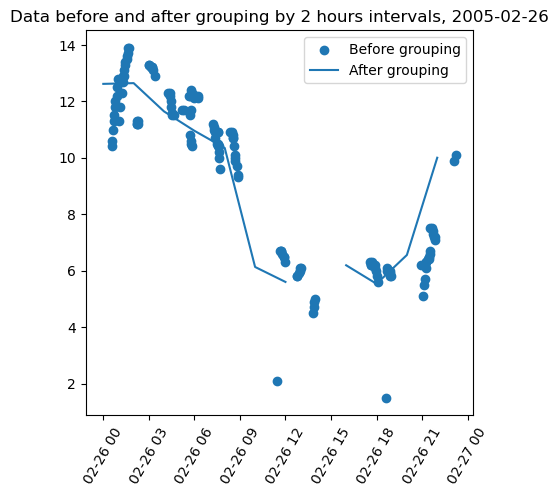

In [9]:
plt.figure(figsize=(5, 5))
plt.title('Data before and after grouping by 2 hours intervals, 2005-02-26')
plt.scatter(df_siberia['datetime'][(df_siberia['datetime'] >= '2005-02-26') & (df_siberia['datetime'] < '2005-02-27')] , df_siberia['tec'][(df_siberia['datetime'] >= '2005-02-26') & (df_siberia['datetime'] < '2005-02-27')] , label='Before grouping')
plt.plot(df_siberia_equilibrate_2hourly['datetime'][(df_siberia_equilibrate_2hourly['datetime'] >= '2005-02-26') & (df_siberia_equilibrate_2hourly['datetime'] < '2005-02-27')] , df_siberia_equilibrate_2hourly['tec'][(df_siberia_equilibrate_2hourly['datetime'] >= '2005-02-26') & (df_siberia_equilibrate_2hourly['datetime'] < '2005-02-27')] , label='After grouping')
plt.xticks(rotation=60)
plt.legend()
plt.show()

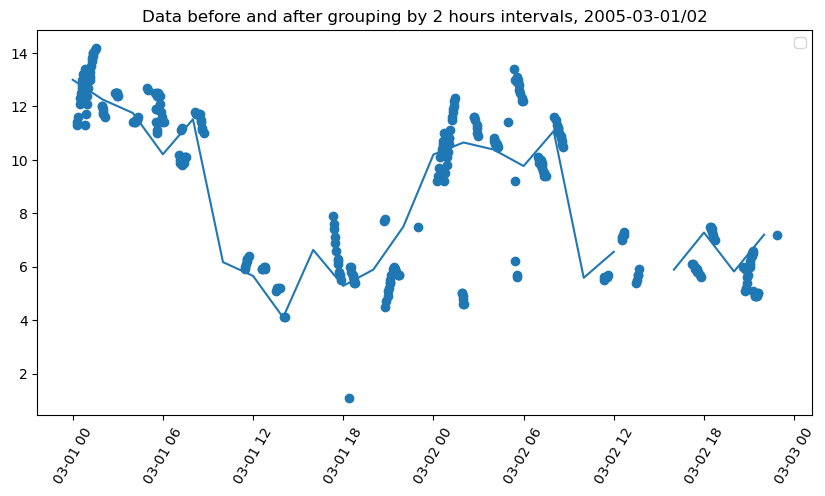

In [10]:
plt.figure(figsize=(10, 5))
plt.title('Data before and after grouping by 2 hours intervals, 2005-03-01/02')
plt.scatter(df_siberia['datetime'][(df_siberia['datetime'] >= '2005-03-01') & (df_siberia['datetime'] < '2005-03-03')] , df_siberia['tec'][(df_siberia['datetime'] >= '2005-03-01') & (df_siberia['datetime'] < '2005-03-03')] )
plt.plot(df_siberia_equilibrate_2hourly['datetime'][(df_siberia_equilibrate_2hourly['datetime'] >= '2005-03-01') & (df_siberia_equilibrate_2hourly['datetime'] < '2005-03-03')] , df_siberia_equilibrate_2hourly['tec'][(df_siberia_equilibrate_2hourly['datetime'] >= '2005-03-01') & (df_siberia_equilibrate_2hourly['datetime'] < '2005-03-03')] )
plt.xticks(rotation=60)
plt.legend()
plt.show()

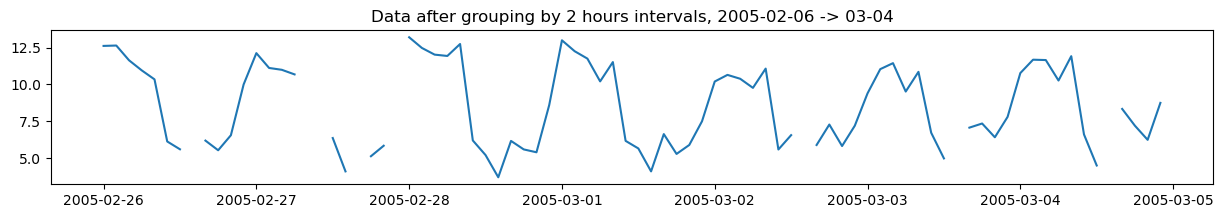

In [11]:
plt.figure(figsize=(15, 2))
plt.title('Data after grouping by 2 hours intervals, 2005-02-06 -> 03-04')
plt.plot(df_siberia_equilibrate_2hourly['datetime'][(df_siberia_equilibrate_2hourly['datetime'] >= '2005-02-26') & (df_siberia_equilibrate_2hourly['datetime'] < '2005-03-05')] , df_siberia_equilibrate_2hourly['tec'][(df_siberia_equilibrate_2hourly['datetime'] >= '2005-02-26') & (df_siberia_equilibrate_2hourly['datetime'] < '2005-03-05')] )
plt.show()


Une approche naïve de gérer les valeurs manquantes serait d'interpoler linéairement : 

In [12]:
df_siberia_equilibrate_2hourly = df_siberia_equilibrate_2hourly.set_index('datetime')
df_siberia_equilibrate_2hourly_linear = df_siberia_equilibrate_2hourly.interpolate(method='linear')
df_siberia_equilibrate_2hourly_linear = df_siberia_equilibrate_2hourly_linear.reset_index()
df_siberia_equilibrate_2hourly_linear

,datetime,tec
0,2003-01-01 00:00:00,13.508333
1,2003-01-01 02:00:00,16.729630
2,2003-01-01 04:00:00,14.066667
3,2003-01-01 06:00:00,10.376744
4,2003-01-01 08:00:00,7.561289
...,...,...
13148,2005-12-31 16:00:00,5.123077
13149,2005-12-31 18:00:00,5.097902
13150,2005-12-31 20:00:00,5.072727
13151,2005-12-31 22:00:00,7.966667


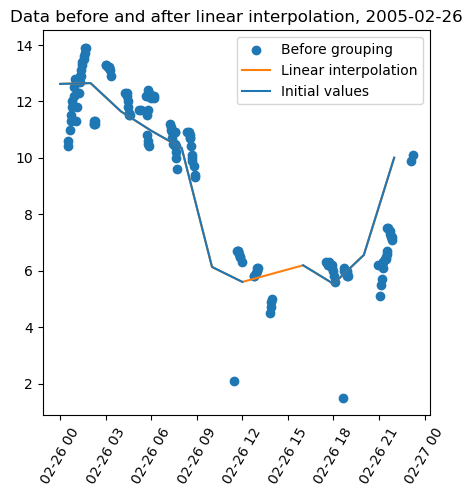

In [13]:
plt.figure(figsize=(5, 5))
plt.title('Data before and after linear interpolation, 2005-02-26')
plt.scatter(df_siberia['datetime'][(df_siberia['datetime'] >= '2005-02-26') & (df_siberia['datetime'] < '2005-02-27')] , df_siberia['tec'][(df_siberia['datetime'] >= '2005-02-26') & (df_siberia['datetime'] < '2005-02-27')] , label='Before grouping', color='tab:blue')
plt.plot(df_siberia_equilibrate_2hourly_linear['datetime'][(df_siberia_equilibrate_2hourly_linear['datetime'] >= '2005-02-26') & (df_siberia_equilibrate_2hourly_linear['datetime'] < '2005-02-27')] , df_siberia_equilibrate_2hourly_linear['tec'][(df_siberia_equilibrate_2hourly_linear['datetime'] >= '2005-02-26') & (df_siberia_equilibrate_2hourly_linear['datetime'] < '2005-02-27')] , color='tab:orange', label='Linear interpolation')
plt.plot(df_siberia_equilibrate_2hourly[(df_siberia_equilibrate_2hourly.index >= '2005-02-26') & (df_siberia_equilibrate_2hourly.index < '2005-02-27')] , color='tab:blue', label='Initial values')
plt.xticks(rotation=60)
plt.legend()
plt.show()

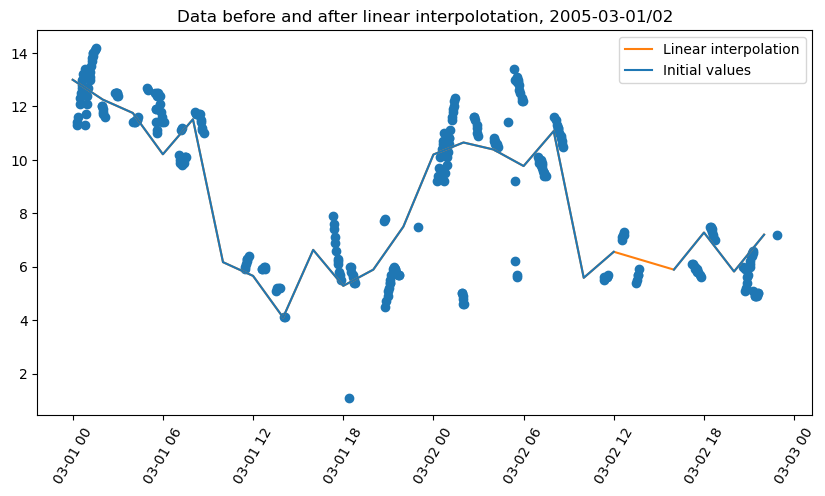

In [14]:
plt.figure(figsize=(10, 5))
plt.title('Data before and after linear interpolotation, 2005-03-01/02')
plt.scatter(df_siberia['datetime'][(df_siberia['datetime'] >= '2005-03-01') & (df_siberia['datetime'] < '2005-03-03')] , df_siberia['tec'][(df_siberia['datetime'] >= '2005-03-01') & (df_siberia['datetime'] < '2005-03-03')] )
plt.plot(df_siberia_equilibrate_2hourly_linear['datetime'][(df_siberia_equilibrate_2hourly_linear['datetime'] >= '2005-03-01') & (df_siberia_equilibrate_2hourly_linear['datetime'] < '2005-03-03')] , df_siberia_equilibrate_2hourly_linear['tec'][(df_siberia_equilibrate_2hourly_linear['datetime'] >= '2005-03-01') & (df_siberia_equilibrate_2hourly_linear['datetime'] < '2005-03-03')], color='tab:orange', label='Linear interpolation')
plt.plot(df_siberia_equilibrate_2hourly[(df_siberia_equilibrate_2hourly.index >= '2005-03-01') & (df_siberia_equilibrate_2hourly.index < '2005-03-03')], color='tab:blue', label='Initial values')
plt.xticks(rotation=60)
plt.legend()
plt.show()

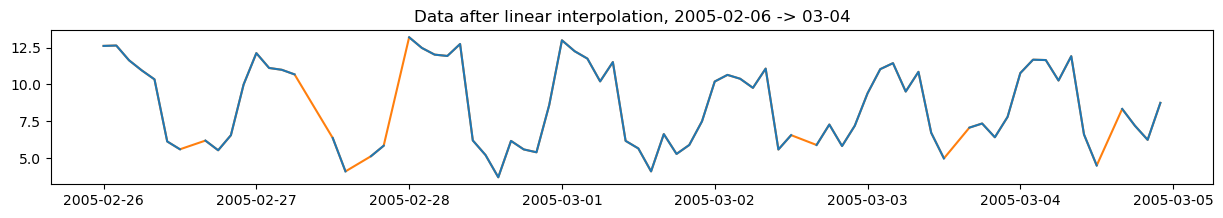

In [15]:
plt.figure(figsize=(15, 2))
plt.title('Data after linear interpolation, 2005-02-06 -> 03-04')
plt.plot(df_siberia_equilibrate_2hourly_linear['datetime'][(df_siberia_equilibrate_2hourly_linear['datetime'] >= '2005-02-26') & (df_siberia_equilibrate_2hourly_linear['datetime'] < '2005-03-05')] , df_siberia_equilibrate_2hourly_linear['tec'][(df_siberia_equilibrate_2hourly_linear['datetime'] >= '2005-02-26') & (df_siberia_equilibrate_2hourly_linear['datetime'] < '2005-03-05')], color='tab:orange', label='Linear interpolation')
plt.plot(df_siberia_equilibrate_2hourly [(df_siberia_equilibrate_2hourly.index >= '2005-02-26') & (df_siberia_equilibrate_2hourly.index < '2005-03-05')], color='tab:blue', label='Initial values' )
plt.show()


Néanmoins, l'interpolation linéaire ne semble pas très adaptée car on voit qu'il y a de nombreux pics indésirables que l'on voudrait lisser.
Nous avons donc décidé d'implémenter l'algorithme d'interpolation de bas rang de la matrice de trajectoires vu dans le cours 4 "Data Enhancement and Preprocessings" :

In [16]:
def create_trajectory_matrix(time_series, window):
    """
    Create trajectory matrix from time series using sliding window.
    
    Args:
        time_series (array-like): Input time series
        window (int): Window size
        
    Returns:
        np.ndarray: Trajectory matrix
    """
    n = len(time_series)
    k = n - window + 1
    matrix = np.zeros((k, window))
    
    for i in range(k):
        matrix[i, :] = time_series[i:i + window]
        
    return matrix

Afin d'avoir une idée du rang de la matrice de trajectoires, on effectue une décomposition en valeurs singulières de la matrice de trajectoires et on regarde si un seuil apparaît.

In [17]:
X = create_trajectory_matrix(df_siberia_equilibrate_2hourly_linear['tec'], 60) 
s = svd(X, full_matrices=False, compute_uv=False)
s / s.sum()

array([0.36013904, 0.07742756, 0.0773107 , 0.03035009, 0.0301    ,
       0.02745346, 0.01975085, 0.01637669, 0.01482175, 0.01335133,
       0.01272474, 0.01261125, 0.01246403, 0.01214476, 0.01203888,
       0.011944  , 0.01180447, 0.01101015, 0.00974278, 0.00962792,
       0.00887624, 0.00880727, 0.00830528, 0.00797322, 0.00769294,
       0.00743556, 0.00719022, 0.00704213, 0.00702759, 0.00685008,
       0.00621915, 0.00590583, 0.00565625, 0.00561941, 0.00551931,
       0.00551025, 0.00542227, 0.0051704 , 0.00514342, 0.00511255,
       0.00503922, 0.0049954 , 0.00494108, 0.00486973, 0.00486836,
       0.00473369, 0.00448038, 0.00447114, 0.00442081, 0.00422515,
       0.00413831, 0.00411948, 0.00384271, 0.00383278, 0.00371009,
       0.00363157, 0.00360716, 0.00356297, 0.00342179, 0.00341436])

In [18]:
np.cumsum(s / s.sum())[24]

np.float64(0.824849411221441)

In [19]:
def low_rank_interpolate(X, W, K, max_iter=100, tol=1e-6):
    """
    Interpolate missing values in trajectory matrix using low rank approximation.
    
    Args:
        X (np.ndarray): Trajectory matrix with missing values
        W (np.ndarray): Mask matrix (1 for observed, 0 for missing)
        K (int): Expected rank
        max_iter (int): Maximum iterations
        tol (float): Convergence tolerance
        
    Returns:
        np.ndarray: Interpolated trajectory matrix
    """
    X_hat = np.zeros_like(X)
    X_hat[W == 0] = np.mean(X[W == 1])  # Initialize missing values with mean

    prev_norm = np.inf
    prev_criterion = np.inf
    for _ in tqdm(range(max_iter)):
        # Combine observed values from X and interpolated values from X_hat
        Y = X + X_hat * (1 - W)
        
        # SVD computation
        U, s, Vt = svd(Y, full_matrices=False)
        
        # Low rank approximation
        X_hat = sum(s[k] * np.outer(U[:, k], Vt[k, :]) for k in range(min(K, len(s))))
        
        # Check convergence
        current_norm = np.linalg.norm(X_hat * (1 - W))
        current_criterion = abs(current_norm - prev_norm)
        if current_criterion > prev_criterion: # diverging
            break
        if current_criterion < tol:
            break
        prev_norm = current_norm
        prev_criterion = current_criterion
        
    return X_hat

In [20]:
X = create_trajectory_matrix(df_siberia_equilibrate_2hourly['tec'].to_numpy(), 60)
W = (~np.isnan(X)).astype(int)
X = np.nan_to_num(X)
estimated_trajectory_matrix = low_rank_interpolate(X, W, 24) # keep first 24 singular values 
estimated_trajectory_matrix.shape

 41%|████      | 41/100 [01:51<02:40,  2.71s/it]


(13094, 60)

Pour retrouver une série temporelle unidimensionnelle à partir de la matrice de trajectoires, on prend la moyenne pour chaque point de la série :

In [21]:
def recover_time_series(trajectory_matrix):
    """
    Recover original time series from trajectory matrix using diagonal averaging.
    
    Args:
        trajectory_matrix (np.ndarray): Matrix of shape (n - window_size + 1, window_size)
    
    Returns:
        np.ndarray: Recovered time series of length n
    """
    L = trajectory_matrix.shape[1]  # window_size
    K = trajectory_matrix.shape[0]  # n - window_size + 1
    n = L + K - 1  # original series length
    
    recovered = np.zeros(n)
    counts = np.zeros(n)
    
    # Fill the recovered series using diagonal averaging
    for i in range(K):
        for j in range(L):
            recovered[i + j] += trajectory_matrix[i, j]
            counts[i + j] += 1
            
    # Normalize by the number of elements in each diagonal
    recovered = recovered / counts
    
    return recovered

In [22]:
df_siberia_equilibrate_2hourly_low_rank = pd.DataFrame(recover_time_series(estimated_trajectory_matrix), columns=['tec'], index=df_siberia_equilibrate_2hourly.index)
df_siberia_equilibrate_2hourly_low_rank

,tec
datetime,
2003-01-01 00:00:00,12.979410
2003-01-01 02:00:00,16.913660
2003-01-01 04:00:00,14.652877
2003-01-01 06:00:00,9.981371
2003-01-01 08:00:00,2.330454
...,...
2005-12-31 16:00:00,5.129055
2005-12-31 18:00:00,11.250599
2005-12-31 20:00:00,5.798415


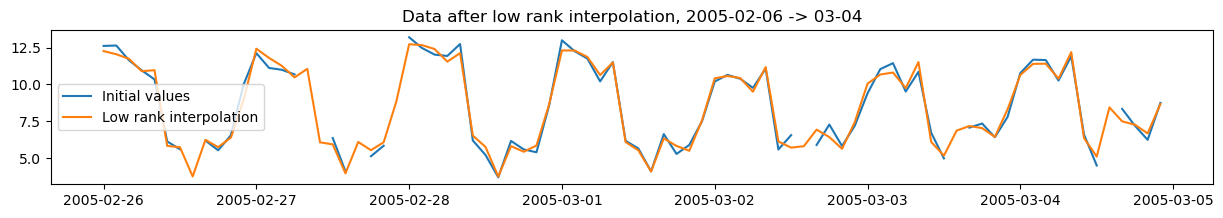

In [23]:
plt.figure(figsize=(15, 2))
plt.title('Data after low rank interpolation, 2005-02-06 -> 03-04')
plt.plot(df_siberia_equilibrate_2hourly['2005-02-26':'2005-03-04'], label='Initial values')
plt.plot(df_siberia_equilibrate_2hourly_low_rank['2005-02-26':'2005-03-04'], label='Low rank interpolation')
plt.legend()
plt.show()


Afin de choisir le meilleur hyperparamètre $K$ pour l'interpolation de bas rang, et ensuite trancher entre l'interpolation linéaire et l'interpolation de bas rang, on procède par validation croisée pour voir quelle technique permet 
de retrouver le mieux les données initiales.

In [ ]:
data = df_siberia_equilibrate_2hourly.reset_index().dropna()#.reset_index(drop=True)
n = len(data)
shuffled_indices = list(np.random.choice(data.index[1:-1], size=n-2, replace=False))
empty_rows = pd.DataFrame(columns=['tec'], index=df_siberia_equilibrate_2hourly [np.array(df_siberia_equilibrate_2hourly.isna())].index)
data = data.set_index('datetime')
data = pd.concat([data, empty_rows])
data = data.sort_index().reset_index().iloc[:-1, :] # to remove the last nan
data

In [ ]:
mse_linear = []
mse_low_rank = {}
for K in [3, 6, 12, 24, 36, 48]:
    mse_low_rank[K] = []

for i in tqdm(range(5)):
    test_indices = shuffled_indices[i*(n-2)//5:(i+1)*(n-2)//5]
    
    data_linear = data.copy()
    data_linear.loc[test_indices, 'tec'] = np.nan
    data_linear = data_linear.set_index('datetime').interpolate(method='linear')
    data_linear = data_linear.reset_index()
    mse_linear.append(mean_squared_error(data.loc[test_indices, 'tec'], data_linear.loc[test_indices, 'tec']))

    for K in [3, 6, 12, 24, 36, 48]:
        data_low_rank = data.copy()
        data_low_rank.loc[test_indices, 'tec'] = np.nan
        X = create_trajectory_matrix(data_low_rank['tec'].to_numpy(), 60)
        W = (~np.isnan(X)).astype(int)
        X = np.nan_to_num(X)
        estimated_trajectory_matrix = low_rank_interpolate(X, W, K) # keep first K singular values 
        data_low_rank = pd.DataFrame(recover_time_series(estimated_trajectory_matrix), columns=['tec'], index=data['datetime']).reset_index()
        mse_low_rank[K].append(mean_squared_error(data.loc[test_indices, 'tec'], data_low_rank.loc[test_indices, 'tec']))
    
print('Linear interpolation MSE:', np.mean(mse_linear), mse_linear)
for K in [3, 6, 12, 24, 36, 48]:
    print(f'Low rank interpolation MSE, K={K}:', np.mean(mse_low_rank[K]), mse_low_rank[K])


On obtient les résultats suivants :

'''

Linear interpolation MSE: 6.150214796765687 [5.895800924038166, 5.876690869066549, 6.641534269460448, 6.2145549344666895, 6.122492986796583]

Low rank interpolation MSE, K=3: 6.335624849607241 [6.187371189739327, 6.2226226024807625, 6.627355497036047, 6.655755898282535, 5.9850190604975335]

Low rank interpolation MSE, K=6: 4.045713915045707 [4.066142555227715, 3.9192922283488882, 4.126730407440175, 4.277248392658959, 3.839155991552797]

Low rank interpolation MSE, K=12: 3.187761565724821 [3.128596299662775, 3.0836813463469745, 3.3234495423506165, 3.267568415896274, 3.1355122243674645]

Low rank interpolation MSE, K=24: 2.9607795658684024 [2.9221743357096988, 3.055058455952831, 3.0258779484597054, 2.825439648895121, 2.9753474403246587]

Low rank interpolation MSE, K=36: 4.757210332515511 [4.4813070763621035, 4.8351039390956645, 4.613850129104625, 4.981786610230705, 4.874003907784458]

Low rank interpolation MSE, K=48: 10.498027573679838 [10.507834834856647, 9.110178932245013, 10.485988859990826, 10.55241648935876, 11.833718751947947]

'''

Par conséquent, nous allons retenir l'interpolation de bas rang avec $K = 24$.

In [24]:
X = create_trajectory_matrix(df_siberia_equilibrate_2hourly['tec'].to_numpy(), 60)
W = (~np.isnan(X)).astype(int)
X = np.nan_to_num(X)
estimated_trajectory_matrix = low_rank_interpolate(X, W, 24) # keep first 24 singular values 
df_siberia_equilibrate_2hourly_low_rank = pd.DataFrame(recover_time_series(estimated_trajectory_matrix), columns=['tec'], index=df_siberia_equilibrate_2hourly.index)

 41%|████      | 41/100 [01:56<02:47,  2.85s/it]


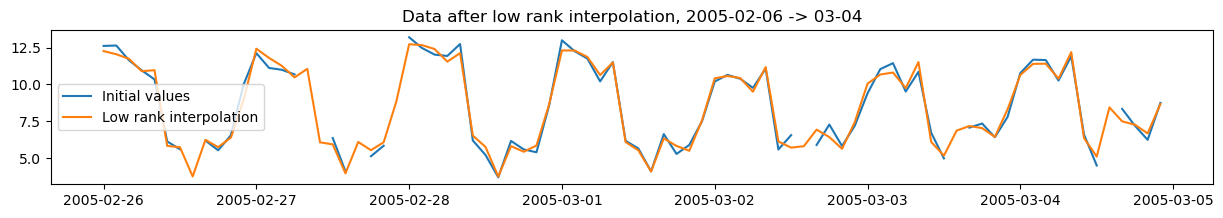

In [25]:
plt.figure(figsize=(15, 2))
plt.title('Data after low rank interpolation, 2005-02-06 -> 03-04')
plt.plot(df_siberia_equilibrate_2hourly['2005-02-26':'2005-03-04'], label='Initial values')
plt.plot(df_siberia_equilibrate_2hourly_low_rank['2005-02-26':'2005-03-04'], label='Low rank interpolation')
plt.legend()
plt.show()


## Modèles

Afin de choisir les hyperparamètres pour nos modèles, en particulier le SARIMA, nous allons chercher à prédire la période du 25 février 2005 au 5 mars 2005, pendant laquelle les conditions géomagnétiques
sont calmes.
La période d'entraînement est de 2 ans avant la période de prédiction, soit de février 2003 à février 2005.

In [26]:
df_siberia_equilibrate_2hourly_low_rank = df_siberia_equilibrate_2hourly_low_rank.reset_index()
train = df_siberia_equilibrate_2hourly_low_rank [(df_siberia_equilibrate_2hourly_low_rank['datetime'] >= '2003-02-25') & (df_siberia_equilibrate_2hourly_low_rank['datetime'] < '2005-02-25')] 
test = df_siberia_equilibrate_2hourly_low_rank [(df_siberia_equilibrate_2hourly_low_rank['datetime'] >= '2005-02-25') & (df_siberia_equilibrate_2hourly_low_rank['datetime'] < '2005-03-06')] 

In [27]:
train = train.set_index('datetime')
test = test.set_index('datetime')

### SARIMA

Afin d'appliquer un modèle de type ARMA, il faut vérifier que la série temporelle est stationnaire. Dans le cas du modèle SARIMA, les paramètres $d$ et $D$ permettent 
de différencier la série afin de la rendre stationnaire.

Clairement, la série n'est pas stationnaire : on observe à la fois une saisonnalité liée à la période de l'année, avec un niveau plus haut l'été et plus bas l'hiver, et une saisonnalité liée à la période dans la journée.

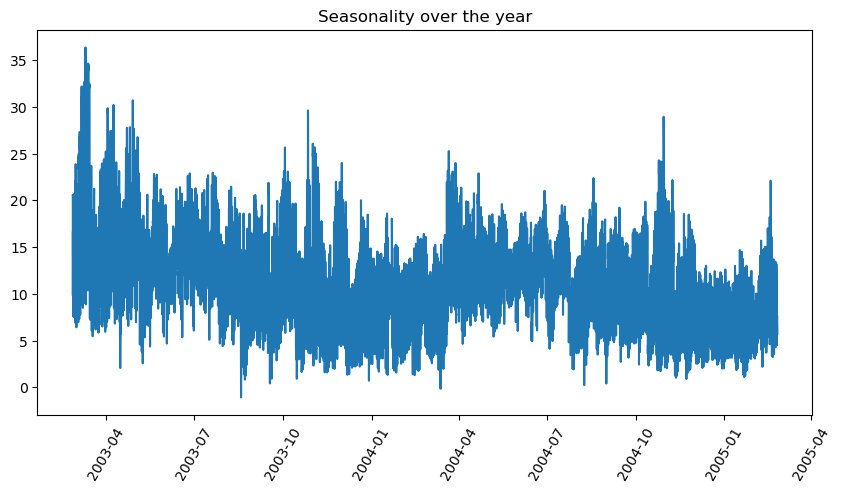

In [28]:
plt.figure(figsize=(10, 5))
plt.title('Seasonality over the year')
plt.plot(train)
plt.xticks(rotation=60)

plt.show()

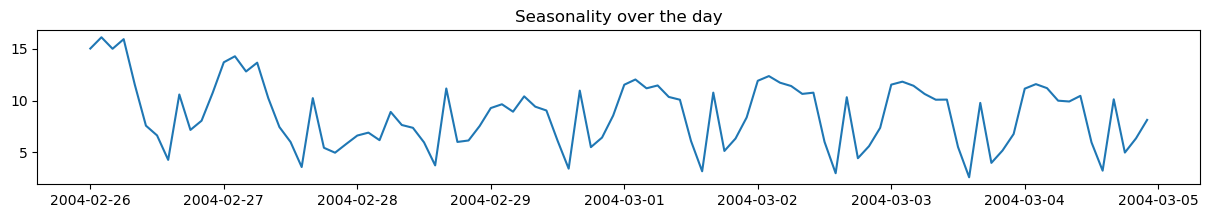

In [29]:
plt.figure(figsize=(15, 2))
plt.title('Seasonality over the day')
plt.plot(train['2004-02-26':'2004-03-04'])

plt.show()

La non-stationnarité de la série est confirmée par l'ACF. L'hypothèse de racine unitaire du test ADF est rejetée mais l'hypothèse de stationnarité du KPSS est également rejetée. Il semble donc prudent de considérer que la série n'est pas stationnaire
et d'effectuer une différentiation.

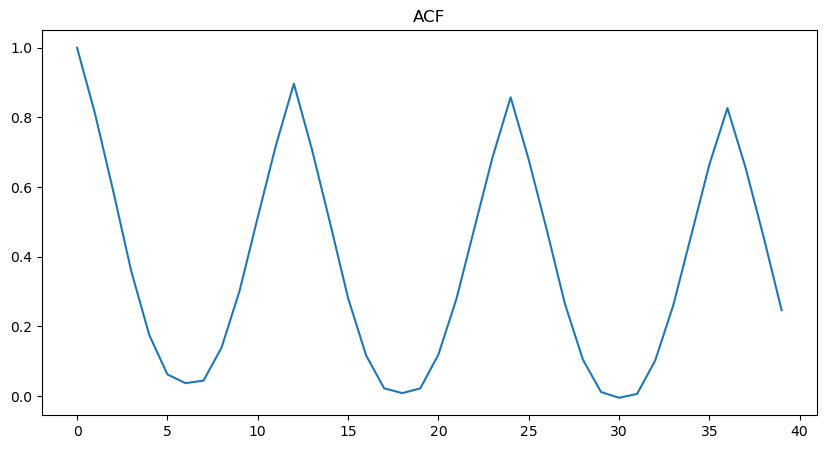

In [30]:
plt.figure(figsize=(10, 5))
plt.title('ACF')
plt.plot(range(40), acf(train))

plt.show()

In [31]:
adfuller(train, autolag='AIC')[1]

np.float64(6.224903054725927e-05)

In [32]:
kpss(train.dropna())[1]

np.float64(0.01)

La série semble stationnaire après une différentiation d'ordre 12 :

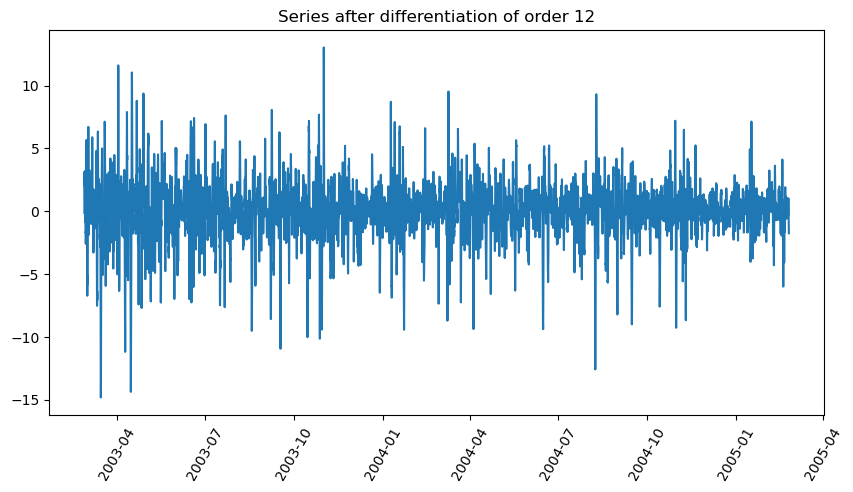

In [33]:
plt.figure(figsize=(10, 5))
plt.title('Series after differentiation of order 12')
plt.plot(train.diff(12))
plt.xticks(rotation=60)

plt.show()

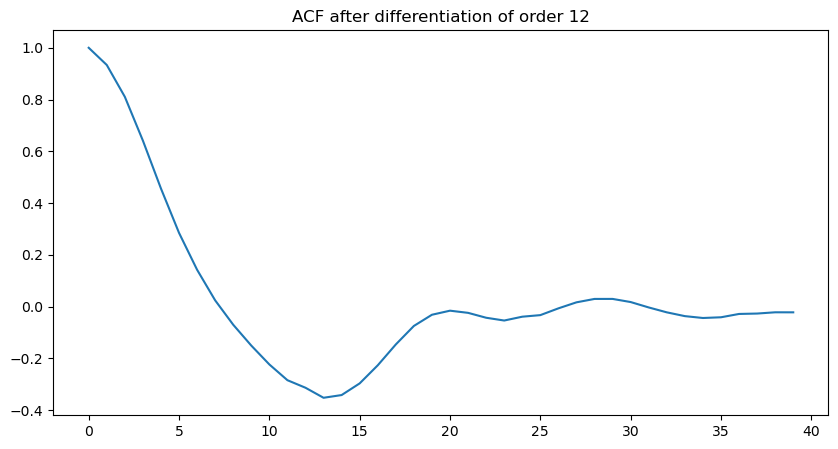

In [34]:
plt.figure(figsize=(10, 5))
plt.title('ACF after differentiation of order 12')
plt.plot(range(40), acf(train.diff(12).dropna()))

plt.show()

Les tests statistiques confirment que la série est stationnaire après la différentiation d'ordre 12.

In [35]:
adfuller(train.diff(12).dropna(), autolag='AIC')[1]

np.float64(1.715559242980294e-29)

In [36]:
kpss(train.diff(12).dropna())[1]

np.float64(0.1)

On choisit donc un modèle avec une période de 12 et des paramètres de différentiation $d=0$ et $D=1$. Pour estimer les paramètres restants, on effectue une grid search et on conserve les paramètres 
avec le meilleur AIC.

In [37]:
def sarimax_grid_search(data, p_range, q_range, P_range, Q_range):
    """
    Perform grid search over SARIMAX parameters (p, q) and (P, Q).
    
    Parameters:
    -----------
    data : array-like
        Time series data to fit
    p_range : list
        Range of p values to test
    q_range : list
        Range of q values to test
    P_range : list
        Range of P values to test
    Q_range : list
        Range of Q values to test
        
    Returns:
    --------
    results_df : pandas DataFrame
        DataFrame containing results for each parameter combination
    best_params : list
        [(p, q), (P, Q)] combination with lowest AIC
    """
    
    # Create all possible combinations of parameters
    pqPQ = list(itertools.product(p_range, q_range, P_range, Q_range))
    
    # Initialize results storage
    results = []
    
    # Grid search
    for param in tqdm(pqPQ):
        try:
            model = SARIMAX(data,
                            order=(param[0], 0, param[1]),
                            seasonal_order=(param[2], 1, param[3], 12))
            model_fit = model.fit(disp=False)
            
            # Store results
            results.append({
                'p': param[0],
                'q': param[1],
                'P': param[2],
                'Q': param[3],
                'aic': model_fit.aic,
                'bic': model_fit.bic,
                'hqic': model_fit.hqic,
                'converged': model_fit.mle_retvals['converged']
            })
            
        except Exception as e:
            results.append({
                'p': param[0],
                'q': param[1],
                'P': param[2],
                'Q': param[3],
                'aic': None,
                'bic': None,
                'hqic': None,
                'converged': False,
                'error': str(e)
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Find best parameters (based on AIC)
    best_params = None
    if not results_df['aic'].isna().all():
        best_idx = results_df['aic'].idxmin()
        best_params = (
            results_df.loc[best_idx, 'p'],
            results_df.loc[best_idx, 'q'],
            results_df.loc[best_idx, 'P'],
            results_df.loc[best_idx, 'Q']
        )
    
    return results_df, best_params

In [58]:
# Define parameter ranges to test
p_range = list(range(0, 3))
q_range = list(range(0, 3))
P_range = list(range(0, 3))
Q_range = list(range(0, 3))

# Perform grid search
results_df, best_params = sarimax_grid_search(train, p_range, q_range, P_range, Q_range)

# Print results
print("\nTop 5 models by AIC:")
print(results_df.sort_values('aic').head())

print("\nBest parameters (p,q), (P,Q):", best_params)

100%|██████████| 81/81 [1:02:42<00:00, 46.45s/it]


Top 5 models by AIC:
    p  q  P  Q           aic           bic          hqic  converged
79  2  2  2  1  14165.922148  14222.545757  14185.215724      False
80  2  2  2  2  14455.595890  14519.297451  14477.301163       True
77  2  2  1  2  14485.262331  14541.885940  14504.555907       True
78  2  2  2  0  14493.102283  14542.647941  14509.984162       True
76  2  2  1  1  14494.522273  14544.067932  14511.404153       True

Best parameters (p,q), (P,Q): (np.int64(2), np.int64(2), np.int64(2), np.int64(1))


'''

100%|██████████| 81/81 [1:02:42<00:00, 46.45s/it]


Top 5 models by AIC:

    p  q  P  Q           aic           bic          hqic  converged

79  2  2  2  1  14165.922148  14222.545757  14185.215724      False

80  2  2  2  2  14455.595890  14519.297451  14477.301163       True

77  2  2  1  2  14485.262331  14541.885940  14504.555907       True

78  2  2  2  0  14493.102283  14542.647941  14509.984162       True

76  2  2  1  1  14494.522273  14544.067932  14511.404153       True

Best parameters (p,q), (P,Q): (np.int64(2), np.int64(2), np.int64(2), np.int64(1))


'''

Nous allons retenir les paramètres (2, 2, 2, 2) car le modèle a convergé.

In [62]:
print(results_df.sort_values('bic').head())


    p  q  P  Q           aic           bic          hqic  converged
79  2  2  2  1  14165.922148  14222.545757  14185.215724      False
80  2  2  2  2  14455.595890  14519.297451  14477.301163       True
77  2  2  1  2  14485.262331  14541.885940  14504.555907       True
78  2  2  2  0  14493.102283  14542.647941  14509.984162       True
75  2  2  1  0  14500.424964  14542.892671  14514.895146       True


In [38]:
# Fit model with best parameters
best_model = SARIMAX(train, order=(2, 0, 2), seasonal_order=(2, 1, 2, 12)).fit(disp=False)
print("\nBest model summary:")
print(best_model.summary().tables[1])


Best model summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6762      0.007    239.124      0.000       1.662       1.690
ar.L2         -0.7763      0.007   -110.576      0.000      -0.790      -0.763
ma.L1         -0.0972      0.009    -10.621      0.000      -0.115      -0.079
ma.L2          0.3621      0.009     40.303      0.000       0.344       0.380
ar.S.L12      -0.2781      0.027    -10.327      0.000      -0.331      -0.225
ar.S.L24       0.5645      0.020     28.455      0.000       0.526       0.603
ma.S.L12       0.9719      0.028     34.408      0.000       0.917       1.027
ma.S.L24       0.0925      0.012      7.492      0.000       0.068       0.117
sigma2         0.3045      0.003    114.162      0.000       0.299       0.310


In [39]:
predict = best_model.forecast(steps=216)
predict

2005-02-25 00:00:00    11.277855
2005-02-25 02:00:00    11.086637
2005-02-25 04:00:00    11.154894
2005-02-25 06:00:00    10.706981
2005-02-25 08:00:00    11.176095
                         ...    
2005-03-14 14:00:00     5.536581
2005-03-14 16:00:00     7.086970
2005-03-14 18:00:00     4.852371
2005-03-14 20:00:00     3.831473
2005-03-14 22:00:00     5.231180
Freq: 2h, Name: predicted_mean, Length: 216, dtype: float64

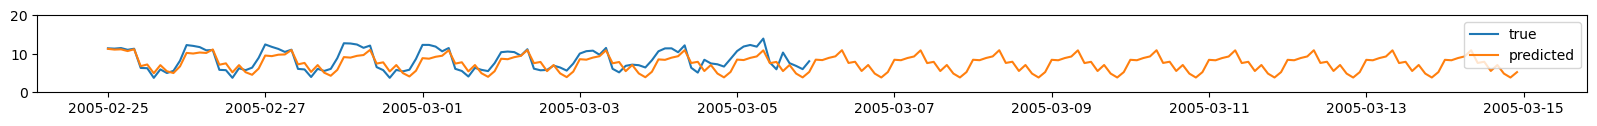

In [40]:
plt.figure(figsize=(20, 1))
plt.ylim(0, 20)
plt.plot(test, label='true')
plt.plot(predict, label='predicted')
plt.legend()
plt.show()

On vérifie que les résidus sont gaussiens :

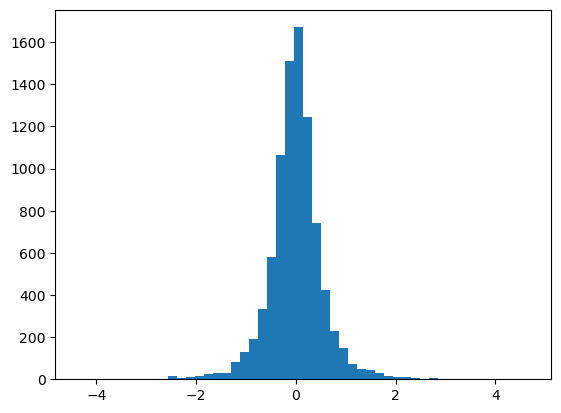

In [41]:
plt.hist(best_model.resid[20:], bins=50)
plt.show()

In [42]:
predict = best_model.forecast(steps=5000)#, typ="level")
predict

2005-02-25 00:00:00    11.277855
2005-02-25 02:00:00    11.086637
2005-02-25 04:00:00    11.154894
2005-02-25 06:00:00    10.706981
2005-02-25 08:00:00    11.176095
                         ...    
2006-04-17 06:00:00     9.300904
2006-04-17 08:00:00    10.907423
2006-04-17 10:00:00     7.606948
2006-04-17 12:00:00     7.922880
2006-04-17 14:00:00     5.532982
Freq: 2h, Name: predicted_mean, Length: 5000, dtype: float64

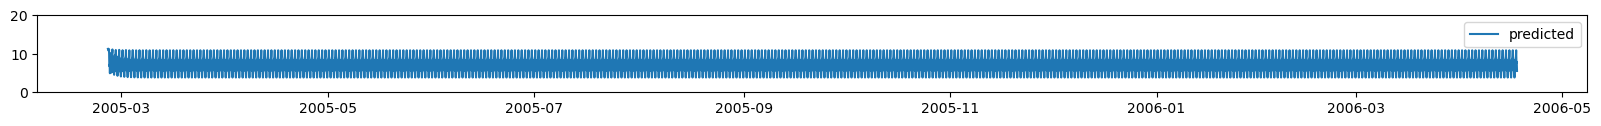

In [43]:
plt.figure(figsize=(20, 1))
plt.ylim(0, 20)
plt.plot(predict, label='predicted')
plt.legend()
plt.show()

Les prédictions ne sont pas valables sur du long terme car la saisonnalité n'est que journalière, donc ça répète la même journée à l'infini, il faudrait prendre en compte la saisonnalité liée à la période de l'année pour des prédictions de long terme.